# Creation of our own model

In [11]:
from carRecognition import display_bounding_boxes

import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
import matplotlib.pylab as plt
import numpy as np

import os
import json
import torch
from torch.utils.data import Dataset, DataLoader, random_split
# from PIL import Image
import torchvision.transforms as transforms
import pandas as pd

import cv2
torch.manual_seed(2)

# https://www.kaggle.com/datasets/sshikamaru/car-object-detection/data

In [12]:
def normalize_boxes(boxes, img_width, img_height):
    # Input boxes format: [x_min, y_min, x_max, y_max]
    boxes[:, [0, 2]] /= img_width
    boxes[:, [1, 3]] /= img_height
    return boxes


In [13]:
# Global variables

NEW_WIDTH = 338
NEW_HEIGHT = 190

# cv2     : [height, width, c]
# pytorch : [channels, height, width]

In [14]:
class CarRecognitionDataset(Dataset):
    def __init__(self, images_dir, csv_annotations, transform=None):
        self.images_dir = images_dir
        self.annotations = pd.read_csv(csv_annotations)
        self.transform = transform

    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.images_dir, self.annotations.iloc[index, 0])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # for display
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # enough to have 1 channel...
        image = image[:,:,:3] # removing alpha cannal if it exists
        # must be (c, height, width)
        # note : trasnform.ToTensor() does the permute() alone
        y = torch.tensor(self.annotations.iloc[index, 1:5]) # 1:5 for bounding box coord
        y = y/2 # change to ratio

        image = self.transform(image) # transform has to resize


        return image, y

In [15]:
def iou_bboxes(outputs: torch.Tensor, labels: torch.Tensor, smooth=1e-6):
    # outputs et labels sont supposés être de forme [batch_size, 4] avec 4 pour les coordonnées [x_min, y_min, x_max, y_max]
    
    # Calcul des coordonnées de l'intersection
    x1 = torch.max(outputs[:, 0], labels[:, 0])
    y1 = torch.max(outputs[:, 1], labels[:, 1])
    x2 = torch.min(outputs[:, 2], labels[:, 2])
    y2 = torch.min(outputs[:, 3], labels[:, 3])
    
    # Calcul de l'aire de l'intersection
    intersection = torch.clamp(x2 - x1, min=0) * torch.clamp(y2 - y1, min=0)
    
    # Calcul de l'aire de chaque boîte
    area_output = (outputs[:, 2] - outputs[:, 0]) * (outputs[:, 3] - outputs[:, 1])
    area_label = (labels[:, 2] - labels[:, 0]) * (labels[:, 3] - labels[:, 1])
    
    # Calcul de l'aire de l'union
    union = area_output + area_label - intersection + smooth  # Ajout de smooth pour éviter la division par zéro
    
    # Calcul de l'IoU
    iou = (intersection + smooth) / union
    return iou.mean()  # Retourne l'IoU moyen pour le batch

In [16]:
dataset = CarRecognitionDataset(csv_annotations='data/train_boxes.csv', images_dir='data/train/',
                                 transform = transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Resize((NEW_HEIGHT, NEW_WIDTH))
                                 ]))

In [17]:
train_size = int(0.90 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, drop_last=True)

In [18]:
def train(model, criterion, train_loader, optimizer, epochs=10):
    i = 0
    output = {'training_loss': [], 'test_accuracy': []}  
    
    for epoch in range(epochs):
        print(str(epoch) + " / " + str(epochs))
        for i, (image, box) in enumerate(train_loader):
            image=image.float()
            box=box.float()
            optimizer.zero_grad()
            z = model(image)
            loss = criterion(z, box)
            loss.backward()
            optimizer.step()
            output['training_loss'].append(loss.data.item())
    
    return output

In [ ]:
## CarNet multi-layer
# output_size = (in_size - kernel_size + (2*padding))/stride   + 1
class CarNet(nn.Module):
    def __init__(self):
        super(CarNet, self).__init__()
        # 338, 190
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=0), # to get edge detectors
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4, padding=0)
        )
        # 84, 47
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=0), # stride=2 ?
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        # 40, 21
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0), # padding=(height, width)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        # 19, 9 
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=0), 
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        # 17, 7
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=1, stride=1, padding=0), 
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        # 17, 7 (point-wise convolution)
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(17*7*128, 4096),
            nn.ReLU()
        )
        #
        self.fc2 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 2048),
            nn.ReLU()
        )
        self.fc3 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(2048, 4),
            nn.ReLU()
        )

    def forward(self, img):

        out = self.layer1(img)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out
    

In [34]:
## CarNet2 asymetrical kernel
# output_size = (in_size - kernel_size + (2*padding))/stride   + 1
class CarNet2(nn.Module):
    def __init__(self):
        super(CarNet2, self).__init__()
        # 338, 190
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=0), # to get edges detectors
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        # 168, 94
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 128, kernel_size=(5, 7), stride=1, padding=0), # stride=2 ?
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        # 81, 45
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=1, padding=0), # padding=(height, width)
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        # 39, 21
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=0), 
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        # 18, 9
        self.layer5 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=0), 
            nn.BatchNorm2d(1024),
            nn.ReLU()
        )
        # 16, 7
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(16*7*1024, 8192),
            nn.ReLU()
        )
        #
        self.fc2 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(8192, 4096),
            nn.ReLU()
        )
        self.fc3 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4),
            nn.ReLU()
        )

    def forward(self, img):

        out = self.layer1(img)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out
    

In [39]:
import torch.optim as optim

# images INITIAL shape : 676 x 380

learning_rate = 0.0005
epochs = 10
model = CarNet()

criterion = nn.SmoothL1Loss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.004)

output=train(model, criterion, train_loader, optimizer, epochs)

# TRY TO VISUALIZE THE LOSS OVER E-POCH
# ALSO : IoU for train and test


0 / 10
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10


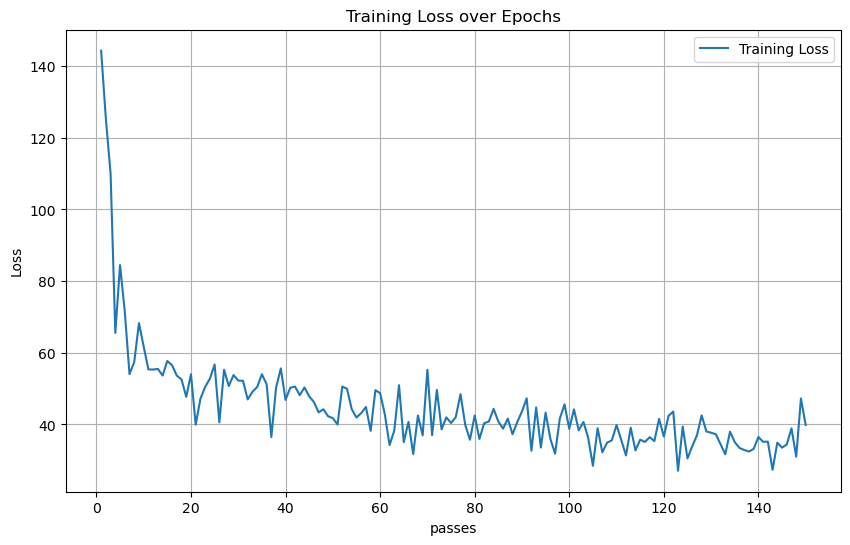

In [40]:
training_loss = output['training_loss']

epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, label='Training Loss')
plt.xlabel('passes')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [41]:
model.eval()
total_iou = 0.0
num_batches = 0
min_iou = 1
max_iou = 0
transform = transforms.Compose([transforms.Resize((NEW_HEIGHT, NEW_WIDTH))])

with torch.no_grad():
    for images, labels in val_loader:

        img = transform(images)
        predictions = model(img)

        a = torchvision.ops.box_iou(predictions, labels)

        # Calcul de l'IoU pour le batch
        batch_iou = iou_bboxes(predictions, labels)
        total_iou += batch_iou.item()
        if batch_iou.item() > max_iou : max_iou = batch_iou.item()
        if batch_iou.item() < min_iou : min_iou = batch_iou.item()
        num_batches += 1

mean_iou = total_iou / num_batches
print(f"Validation IoU: {mean_iou}")
print(f"Max IoU: {max_iou}")
print(f"Min IoU: {min_iou}")


Validation IoU: 0.1883485460756355
Max IoU: 0.1883485460756355
Min IoU: 0.1883485460756355


In [42]:
model.eval()
total_iou = 0.0
num_batches = 0
min_iou = 1
max_iou = 0
transform = transforms.Compose([transforms.Resize((NEW_HEIGHT, NEW_WIDTH))])

with torch.no_grad():
    for images, labels in train_loader:

        img = transform(images)
        predictions = model(img)

        a = torchvision.ops.box_iou(predictions, labels)
        # Calcul de l'IoU pour le batch
        batch_iou = iou_bboxes(predictions, labels)
        if batch_iou.item() > max_iou : max_iou = batch_iou.item()
        if batch_iou.item() < min_iou : min_iou = batch_iou.item()
        total_iou += batch_iou.item()
        num_batches += 1

mean_iou = total_iou / num_batches
print(f"Training IoU: {mean_iou}")
print(f"Max IoU: {max_iou}")
print(f"Min IoU: {min_iou}")


Training IoU: 0.16348810151515628
Max IoU: 0.19956830930922673
Min IoU: 0.11303641523126244


In [ ]:
# temporary, until i implement element-wise IoU (instead of whole batch IoU)
diagonal = a.diag()

# Affichage
print("Diagonale de la matrice IoU :", diagonal)
print("Moyenne des valeurs sur la diagonale :", diagonal.mean().item())

Diagonale de la matrice IoU : tensor([0.0000, 0.0909, 0.0000, 0.4340, 0.2959, 0.0000, 0.0606, 0.0000, 0.3001,
        0.0000, 0.0000, 0.0000, 0.6865, 0.0000, 0.0820, 0.6410, 0.0944, 0.0512,
        0.1395, 0.1452, 0.4696, 0.0000, 0.0000, 0.5675, 0.4927, 0.2811, 0.1473,
        0.0000, 0.0610, 0.0000, 0.0000, 0.0761], dtype=torch.float64)
Moyenne des valeurs sur la diagonale : 0.1598878524140468


done
tensor([[181.0525,  87.8316, 250.9752, 116.4711]])


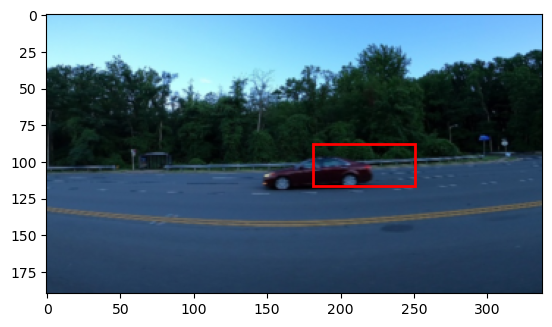

tensor([[280.6819,  81.5474, 335.7556, 101.9108]])


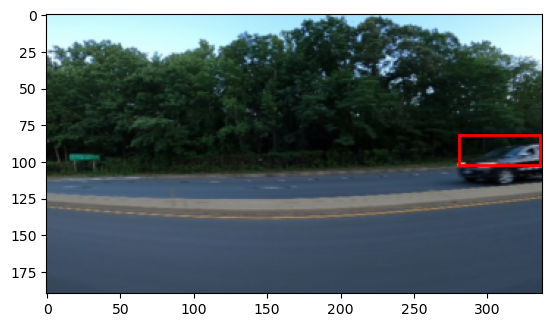

tensor([[128.6214,  80.3988, 185.1415, 102.9225]])


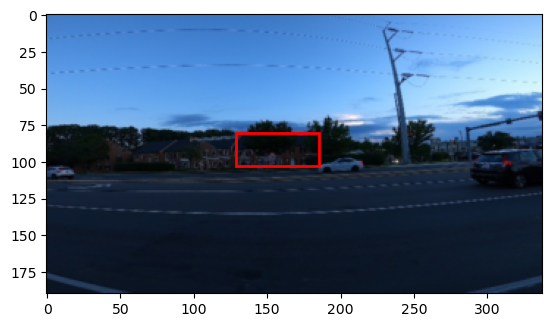

tensor([[ 60.8081,  87.0013, 115.0419, 108.9368]])


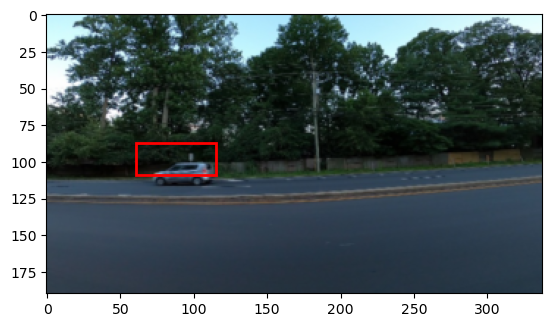

tensor([[172.9714,  86.4796, 237.3188, 111.7645]])


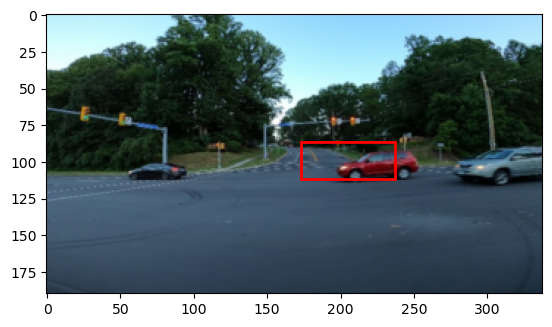

In [26]:
model.eval()
for name, param in model.named_parameters():
    param.requires_grad = False
print("done")

img_list = []
for img, label in train_loader:
    img_list = img[:5]

for img in img_list :
    img = img.unsqueeze(0)
    pred = model(img)
    print(pred)
    img = img.squeeze(0)
    display_bounding_boxes(img.permute(1,2,0).numpy(), pred) # -> [H, W, C]

done
torch.Size([3, 190, 338])


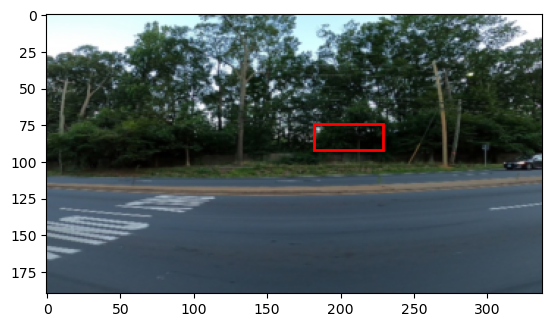

torch.Size([3, 190, 338])


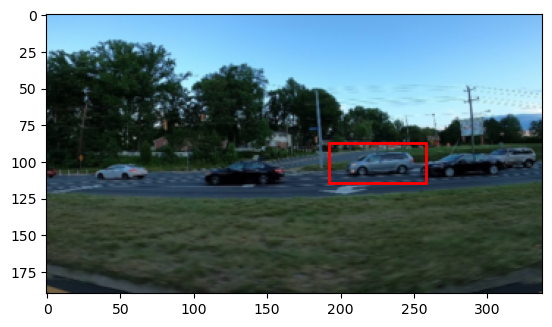

torch.Size([3, 190, 338])


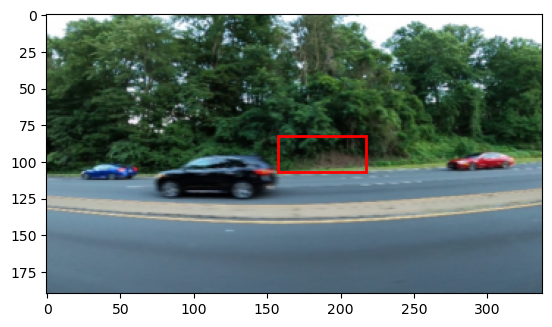

torch.Size([3, 190, 338])


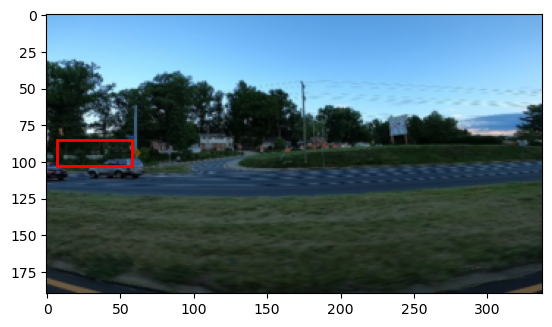

torch.Size([3, 190, 338])


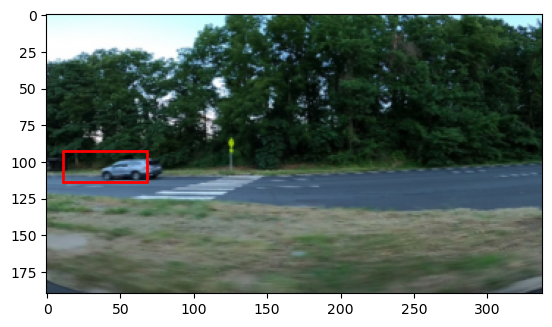

In [25]:
model.eval()
for name, param in model.named_parameters():
    param.requires_grad = False
print("done")

img_list = []
for img, label in val_loader:
    img_list = img[:5]

for img in img_list :
    img = img.unsqueeze(0)
    pred = model(img)
    img = img.squeeze(0)
    print(img.shape)
    display_bounding_boxes(img.permute(1,2,0).numpy(), pred) # -> [H, W, C]